In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit

diabetes_dataset = pd.read_csv('diabetic_data.csv')
diabetes_dataset.drop(axis=1, columns=['weight', 'medical_specialty', 'payer_code'], inplace=True)
diabetes_dataset = diabetes_dataset.sort_values(by=['patient_nbr', 'encounter_id'])
# Define the ranges and replacement values
ICD9_mapping = [
    ((1, 139), 'Infectious And Parasitic Diseases'),
    ((140, 239), 'Neoplasms'),
    ((240, 279), 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders'),
    ((280, 289), 'Diseases Of The Blood And Blood-Forming Organs'), 
    ((290, 319), 'Mental Disorders'),
    ((320, 389), 'Diseases Of The Nervous System And Sense Organs'),
    ((390, 459), 'Diseases Of The Circulatory System'), 
    ((460, 519), 'Diseases Of The Respiratory System'),
    ((520, 579), 'Diseases Of The Digestive System'),
    ((580, 629), 'Diseases Of The Genitourinary System'), 
    ((630, 679), 'Complications Of Pregnancy, Childbirth, And The Puerperium'),
    ((680, 709), 'Diseases Of The Skin And Subcutaneous Tissue'),
    ((710, 739), 'Diseases Of The Musculoskeletal System And Connective Tissue'),
    ((740, 759), 'Congenital Anomalies'), 
    ((760, 779), 'Certain Conditions Originating In The Perinatal Period'),
    ((780, 799), 'Symptoms, Signs, And Ill-Defined Conditions'),
    ((800, 999), 'Injury And Poisoning'),
    ('V', 'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services'),
    ('E', 'Supplementary Classification Of External Causes Of Injury And Poisoning')
]

# Custom function to replace values based on multiple ranges
def replace_multiple_ranges(x, ranges_and_values):
    for values, new_value in ranges_and_values:
        if type(values) == tuple and x[0] != 'V' and x[0] != 'E' and x != '?':
            if values[0] <= int(float(x)) <= values[1]:
                return new_value
        elif type(values) == str and x[0] == values:
            return new_value
    return x

In [2]:
# Apply the custom function to the diagnosis columns
diabetes_dataset['diag_1'] = diabetes_dataset['diag_1'].apply(replace_multiple_ranges, args=(ICD9_mapping,))
diabetes_dataset['diag_2'] = diabetes_dataset['diag_2'].apply(replace_multiple_ranges, args=(ICD9_mapping,))
diabetes_dataset['diag_3'] = diabetes_dataset['diag_3'].apply(replace_multiple_ranges, args=(ICD9_mapping,))

# Replace '?' with 'no record' across diag_2 and diag_3
diabetes_dataset[['diag_2', 'diag_3']] = diabetes_dataset[['diag_2', 'diag_3']].replace('?', 'no record')

# Replace '?' with NaN
diabetes_dataset[['race', 'diag_1']] = diabetes_dataset[['race', 'diag_1']].replace('?', np.nan)

# Drop rows with missing values in columns 'race' and 'diag_1'
diabetes_dataset.dropna(subset=['race', 'diag_1'], inplace=True)

In [3]:
admission_type_id_mapping = {1:'Emergency',
                             2:'Urgent',
                             3:'Elective',
                             4:'Newborn',
                             5:'Not Available',
                             6:'NULL',
                             7:'Trauma Center',
                             8:'Not Mapped'
                            }

discharge_disposition_id_mapping = {1: 'ischarged to home',
                                    2:'ischarged/transferred to another short term hospital',
                                    3:'ischarged/transferred to SNF',
                                    4:'ischarged/transferred to ICF',
                                    5:'ischarged/transferred to another type of inpatient care institution',
                                    6:'ischarged/transferred to home with home health service',
                                    7:'eft AMA',
                                    8:'ischarged/transferred to home under care of Home IV provider',
                                    9:'dmitted as an inpatient to this hospital',
                                    10:'Neonate discharged to another hospital for neonatal aftercare',
                                    11:'Expired',
                                    12:'Still patient or expected to return for outpatient services',
                                    13:'Hospice / home',
                                    14:'Hospice / medical facility',
                                    15:'Discharged/transferred within this institution to Medicare approved swing bed',
                                    16:'Discharged/transferred/referred another institution for outpatient services',
                                    17:'Discharged/transferred/referred to this institution for outpatient services',
                                    18:'NULL',
                                    19:'Expired at home. Medicaid only, hospice.',
                                    20:'Expired in a medical facility. Medicaid only, hospice.',
                                    21:'Expired, place unknown. Medicaid only, hospice.',
                                    22:'Discharged/transferred to another rehab fac including rehab units of a hospital.',
                                    23:'Discharged/transferred to a long term care hospital.',
                                    24:'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.',
                                    25:'Not Mapped',
                                    26:'Unknown/Invalid',
                                    30:'Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere',
                                    27:'Discharged/transferred to a federal health care facility.',
                                    28:'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
                                    29:'Discharged/transferred to a Critical Access Hospital (CAH).'
                                    }

admission_source_id_mapping = {1: 'Physician Referral',
                               2: 'Clinic Referral',
                               3: 'HMO Referral',
                               4: 'Transfer from a hospital',
                               5: 'Transfer from a Skilled Nursing Facility (SNF)',
                               6: 'Transfer from another health care facility',
                               7: 'Emergency Room',
                               8: 'Court/Law Enforcement',
                               9: 'Not Available',
                               10:' Transfer from critial access hospital',
                               11:' Normal Delivery',
                               12:' Premature Delivery',
                               13:' Sick Baby',
                               14:' Extramural Birth',
                               15:' Not Available',
                               17:' NULL',
                               18:' Transfer From Another Home Health Agency',
                               19:' Readmission to Same Home Health Agency',
                               20:' Not Mapped',
                               21:' Unknown/Invalid',
                               22:' Transfer from hospital inpt/same fac reslt in a sep claim',
                               23:' Born inside this hospital',
                               24:' Born outside this hospital',
                               25:' Transfer from Ambulatory Surgery Center',
                               26:' Transfer from Hospice'
                               }

diabetes_dataset['admission_type_id'] = diabetes_dataset['admission_type_id'].replace(admission_type_id_mapping)
diabetes_dataset['discharge_disposition_id'] = diabetes_dataset['discharge_disposition_id'].replace(discharge_disposition_id_mapping)
diabetes_dataset['admission_source_id'] = diabetes_dataset['admission_source_id'].replace(admission_source_id_mapping)

In [4]:
# Function to calculate differences between consecutive rows
def calculate_differences(diabetes_dataset, idx1, idx2):
    differences = {}
    for column in diabetes_dataset.columns:
        if column != 'readmitted':
            if pd.api.types.is_numeric_dtype(diabetes_dataset[column]):
                differences[column] = diabetes_dataset.at[idx1, column] - diabetes_dataset.at[idx2, column]
            else:
                differences[column] = 1 if diabetes_dataset.at[idx1, column] != diabetes_dataset.at[idx2, column] else 0
    return differences

# Function to identify shifts and calculate differences within a group
def process_group(group):
    shifts = ((group['readmitted'] == '<30') & ((group['readmitted'].shift(1) == 'NO') | (group['readmitted'].shift(1) == '>30')))
    shift_indices = group.index[shifts]
    

    differences_list = []
    for idx in shift_indices:
        if idx > group.index.min():
            prev_idx = group.index[group.index.get_loc(idx) - 1]  # Safely get the previous index
            differences = calculate_differences(group, prev_idx, idx)
            differences_list.append(differences)
    
    return differences_list

In [5]:
# Apply the function to each group and collect all differences
all_differences = []
for patient_id, group in diabetes_dataset.groupby('patient_nbr'):
    all_differences.extend(process_group(group))

# Convert list of differences to a DataFrame
differences_diabetes_dataset = pd.DataFrame(all_differences)

# Calculate the mean differences (normalize by the number of shifts)
normalized_differences = differences_diabetes_dataset.abs().mean()

# Get feature names with normalized difference value below 0.01
features_below_threshold = normalized_differences[normalized_differences < 0.01].index.tolist()


# Ensure the column to keep is not in the columns to drop
columns_to_drop = [col for col in features_below_threshold if col != 'patient_nbr']

diabetes_dataset_important_features = diabetes_dataset.drop(columns_to_drop, axis=1)
diabetes_dataset_important_features.drop(['encounter_id'], axis=1, inplace=True)

In [6]:
def sparse_encode(df):
    # select all categorical columns
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']

    # Convert string columns to categorical
    for col in categorical_columns:
        df[col] = df[col].astype('category')
        df[col] = df[col].cat.codes.astype('category')


In [7]:
# Define the unique identifier column
def load_data(df):

    # encode dataframe first
    sparse_encode(df)
    
    unique_id_column = 'patient_nbr'

    # Split into training and remaining sets (validation + test)
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
    train_idx, remaining_idx = next(splitter.split(df, groups=df[unique_id_column]))

    train_df = df.iloc[train_idx]
    test_df = df.iloc[remaining_idx]

    # Split remaining set into validation and test sets
    #splitter = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    #val_idx, test_idx = next(splitter.split(remaining_df, groups=remaining_df[unique_id_column]))

    #val_df = remaining_df.iloc[val_idx]
    #test_df = remaining_df.iloc[test_idx]

    # remove patient number after use for splitting
    train_df, test_df = train_df.drop(['patient_nbr'], axis=1), test_df.drop(['patient_nbr'], axis=1)

    train_y = train_df['readmitted']
    train_df.drop(['readmitted'], axis=1, inplace=True)
    train_x = train_df

    test_y = test_df['readmitted']
    test_df.drop(['readmitted'], axis=1, inplace=True)
    test_x = test_df

    return train_x, train_y, test_x, test_y

Unfiltered loaded dataset

In [8]:
#diabetes_dataset = diabetes_dataset.drop(['encounter_id'], axis=1)

train_features, train_labels, test_features, test_labels = load_data(diabetes_dataset)
print(train_features)

        encounter_id race gender age admission_type_id  \
5827        29758806    2      0   5                 0   
67608      189899286    2      0   8                 1   
1164         8380170    0      0   5                 1   
5953        30180318    0      0   5                 1   
14180       55533660    0      0   6                 1   
...              ...  ...    ...  ..               ...   
95283      359725880    1      0   7                 1   
95282      359719064    4      1   6                 1   
93651      338462954    2      0   8                 1   
101748     443811536    2      0   4                 1   
96147      371459060    2      1   4                 7   

       discharge_disposition_id admission_source_id  time_in_hospital  \
5827                         19                  13                 2   
67608                        21                  10                 4   
1164                         19                  10                 6   
5953       

Filtered loaded dataset

In [9]:
filtered_train_features, filtered_train_labels, filtered_test_features, filtered_test_labels = load_data(diabetes_dataset_important_features)

print(filtered_train_features)

       age admission_type_id discharge_disposition_id admission_source_id  \
5827     5                 0                       19                  13   
67608    8                 1                       21                  10   
1164     5                 1                       19                  10   
5953     5                 1                       19                  10   
14180    6                 1                       19                  10   
...     ..               ...                      ...                 ...   
95283    7                 1                       19                  10   
95282    6                 1                       19                  10   
93651    8                 1                       19                  10   
101748   4                 1                       20                  10   
96147    4                 7                       19                  13   

        time_in_hospital  num_lab_procedures  num_procedures  num_medicatio

RuleFit (RQ1)

In [1]:
!pip install git+https://github.com/christophM/rulefit.git

  Cloning https://github.com/christophM/rulefit.git to c:\users\taher\appdata\local\temp\pip-req-build-79um5939
  Resolved https://github.com/christophM/rulefit.git to commit 472b8574b4eb9e565caf1e05ed580998fe2c9a8e
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for RuleFit: filename=RuleFit-0.3-py3-none-any.whl size=8152 sha256=c3b41e589b809d34366002a668fec9150939baabaa3863551e541de8c9230230
  Stored in directory: C:\Users\Taher\AppData\Local\Temp\pip-ephem-wheel-cache-cdd2w3wn\wheels\b0\96\20\f12d41437ad659039df4712cafbea67964fc36056ddbbbd7c2
Successfully built RuleFit


  Running command git clone --filter=blob:none --quiet https://github.com/christophM/rulefit.git 'C:\Users\Taher\AppData\Local\Temp\pip-req-build-79um5939'

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
from rulefit import RuleFit

rf = RuleFit()
rf.fit(filtered_train_features, filtered_train_labels, feature_names=filtered_train_features.columns)

InvalidIndexError: (slice(None, None, None), 10)

In [ ]:
rf.predict(filtered_test_labels)

rules = rf.get_rules()

rules = rules[rules.coef != 0].sort_values("support", ascending=False)

print(rules)

EBM (RQ2)

In [18]:
# Import necessary libraries
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
train_features = filtered_train_features
train_labels = filtered_train_labels
test_features = filtered_test_features
test_labels = filtered_test_labels

# Ensure the features and labels are in the correct shape
train_features = train_features.values
train_labels = train_labels.values
test_features = test_features.values
test_labels = test_labels.values

# Split the data into training and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# Train the EBM model
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(train_features, train_labels)

# Validate the model
val_predictions = ebm.predict(val_features)
classification_rep = classification_report(val_labels, val_predictions, output_dict=True)
print(classification_report(val_labels, val_predictions))

# Extract the most important features
global_explanation = ebm.explain_global()
feature_importances = global_explanation.data()

# Get the feature names from the original dataset
feature_names = filtered_train_features.columns

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances['scores']})
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the top 10 most important features
top_10_importances_df = importances_df.head(10)
print(top_10_importances_df)

# Set the color theme
medical_theme_color = '#00a79d'  # Medical-themed color (teal)

# Prepare the classification report data
labels = list(classification_rep.keys())[:-3]
precision = [classification_rep[label]['precision'] for label in labels]
recall = [classification_rep[label]['recall'] for label in labels]
f1_score = [classification_rep[label]['f1-score'] for label in labels]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

# Plot the feature importances and classification report in a single figure
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Plot the feature importances
ax[0].barh(top_10_importances_df['Feature'], top_10_importances_df['Importance'], color=medical_theme_color)
ax[0].set_xlabel('Importance', fontsize=14)
ax[0].set_ylabel('Feature', fontsize=14)
ax[0].set_title('Top 10 Most Important Features', fontsize=16, fontweight='bold')
ax[0].invert_yaxis()  # Highest importance at the top
ax[0].tick_params(axis='both', which='major', labelsize=12)

# Plot the classification report metrics
rects1 = ax[1].bar(x - width, precision, width, label='Precision', color='#66c2a5')
rects2 = ax[1].bar(x, recall, width, label='Recall', color='#fc8d62')
rects3 = ax[1].bar(x + width, f1_score, width, label='F1-Score', color='#8da0cb')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[1].set_xlabel('Classes', fontsize=14)
ax[1].set_title('Classification Report Metrics', fontsize=16, fontweight='bold')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, fontsize=12)
ax[1].legend(fontsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax[1].annotate('{}'.format(round(height, 2)),
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=12)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


                     Feature  Importance
10          number_inpatient    0.171491
2   discharge_disposition_id    0.128017
14          number_diagnoses    0.049342
3        admission_source_id    0.044781
26               diabetesMed    0.043332
8          number_outpatient    0.035304
11                    diag_1    0.035217
4           time_in_hospital    0.035052
1          admission_type_id    0.033237
9           number_emergency    0.032999


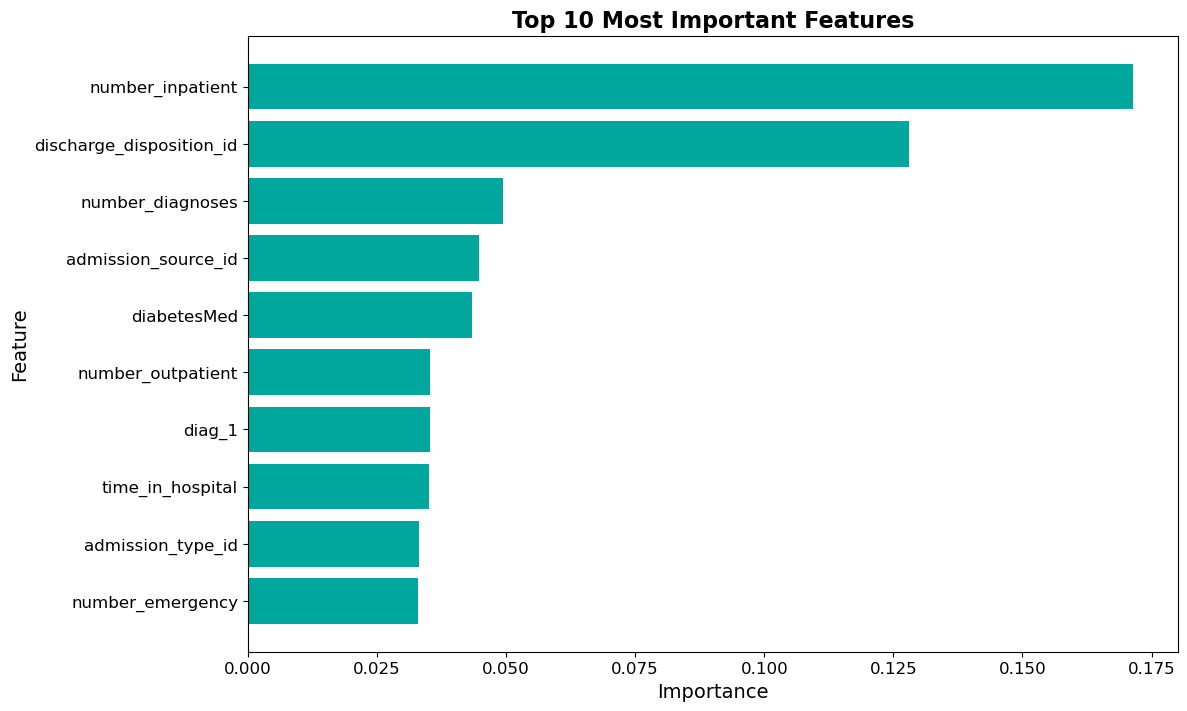